In [126]:

from category_encoders.one_hot import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import metrics
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, confusion_matrix, classification_report,log_loss
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import dalex as dx #explainer for our model
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score

from sklearn import set_config; set_config(display='diagram')
ran = 123
seed = 123

# Load Data

In [127]:
df = pd.read_csv("compas-scores-two-years-clean.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-07-07,2014-07-14,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,Risk of Violence,1,Low,2013-01-26,2013-02-05,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,Risk of Violence,3,Low,2013-06-16,2013-06-16,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,High,Risk of Violence,6,Medium,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,Risk of Violence,1,Low,NaN,NaN,0,1102,0,0


In [128]:
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
      ].dropna(subset=['score_text'])

In [129]:
# Select columns of interest and store as new df
columns = ["id", "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_desc", #current charges
           "score_text", "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "r_charge_degree", "r_charge_desc", #commited crimes (general) within 2 years after COMPAS scoring (no feature for final model, but relevant fro feature engineering)
           "two_year_recid"] #target for classification 
df = df[columns]

To get a clearer picture, we will only use a few columns of the original data frame.


- demographics: "age", "age_cat", "sex", "race"
- criminal history: "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"
- current charges: "c_charge_degree","c_charge_desc"
- truth:"two_year_recid"


Drop duplicate

In [130]:
df.drop_duplicates()

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid
0,1,69,Greater than 45,Male,Other,0,0,0,0,F,Aggravated Assault w/Firearm,Low,1,NaN,NaN,0
1,3,34,25 - 45,Male,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,Low,3,(F3),Felony Battery (Dom Strang),1
2,4,24,Less than 25,Male,African-American,0,0,1,4,F,Possession of Cocaine,Low,4,(M1),Driving Under The Influence,1
5,7,44,25 - 45,Male,Other,0,0,0,0,M,Battery,Low,1,NaN,NaN,0
6,8,41,25 - 45,Male,Caucasian,0,0,0,14,F,Possession Burglary Tools,Medium,6,(F2),Poss of Firearm by Convic Felo,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,10995,20,Less than 25,Male,African-American,0,0,0,0,F,Possession of Cocaine,High,9,NaN,NaN,0
6212,10996,23,Less than 25,Male,African-American,0,0,0,0,F,Deliver Cannabis,Medium,7,NaN,NaN,0
6213,10997,23,Less than 25,Male,African-American,0,0,0,0,F,Leaving the Scene of Accident,Low,3,NaN,NaN,0
6214,10999,57,Greater than 45,Male,Other,0,0,0,0,F,Aggravated Battery / Pregnant,Low,1,NaN,NaN,0


Check dtype of data

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 6215
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5304 non-null   int64 
 1   age              5304 non-null   int64 
 2   age_cat          5304 non-null   object
 3   sex              5304 non-null   object
 4   race             5304 non-null   object
 5   juv_fel_count    5304 non-null   int64 
 6   juv_misd_count   5304 non-null   int64 
 7   juv_other_count  5304 non-null   int64 
 8   priors_count     5304 non-null   int64 
 9   c_charge_degree  5304 non-null   object
 10  c_charge_desc    5299 non-null   object
 11  score_text       5304 non-null   object
 12  decile_score     5304 non-null   int64 
 13  r_charge_degree  2122 non-null   object
 14  r_charge_desc    2095 non-null   object
 15  two_year_recid   5304 non-null   int64 
dtypes: int64(8), object(8)
memory usage: 704.4+ KB


### Feature Engineering: Create feature c_charge_degree_detailed

- The current charges of the ProPublica dataset are categorized as felonies or misdemeanors `c_charge_degreee`
- The c_charge_desc contains the description of the crime (e.g. murder, Grand theft ...)
- In Florida each crime is based on the severness categorised into different level/ classes of misdemeanors or felonies

In [132]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df[df["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df[df["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))

Unique charges in the dataset: 359
Unique charges for felonies: 266
Unique charges for misdemeanors: 126


- In order to reduce the variaty of charges we created a new feature to cluster each crime into the correct level
- The original dataset already contains the more detailed degree of crimes, but only for the recidivist crimes
- We first used these crimes and mapped them against the current charges

### Map charge degree to all cases and store in new feature column c_charge_degree_detailed

In [133]:
# Load master lookup table
labeled_charges_master = pd.read_csv("labeled_charges_master.csv", index_col="c_charge_desc")

In [134]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df= df.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df.reset_index(drop=True, inplace=True)

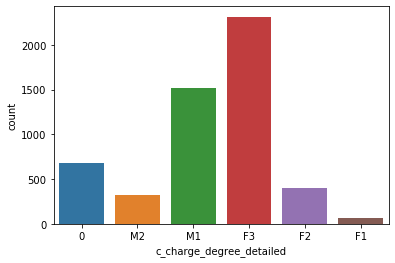

In [135]:
sns.countplot(x="c_charge_degree_detailed", data=df, order=["0","M2", "M1", "F3", "F2", "F1"])

In [136]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df[df.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed
114,243,39,25 - 45,Male,Caucasian,1,0,0,1,M,NaN,Low,4,NaN,NaN,0,NaN
2191,4521,27,25 - 45,Female,Caucasian,0,0,0,0,F,NaN,Medium,5,NaN,NaN,0,NaN
4031,8299,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,4,NaN,NaN,0,NaN
4202,8679,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,3,NaN,NaN,0,NaN
5183,10737,69,Greater than 45,Female,Caucasian,0,0,0,5,F,NaN,Low,3,NaN,NaN,0,NaN


In [137]:
index_nan_cases = df[df.c_charge_degree_detailed.isnull()].index

- There are still 5 cases which did not have a description of the current charges.
- These 5 cases need to be imputed
- This requires the encoding of all categorical features first

# Data Preprocessing

### Initial distribution of the features

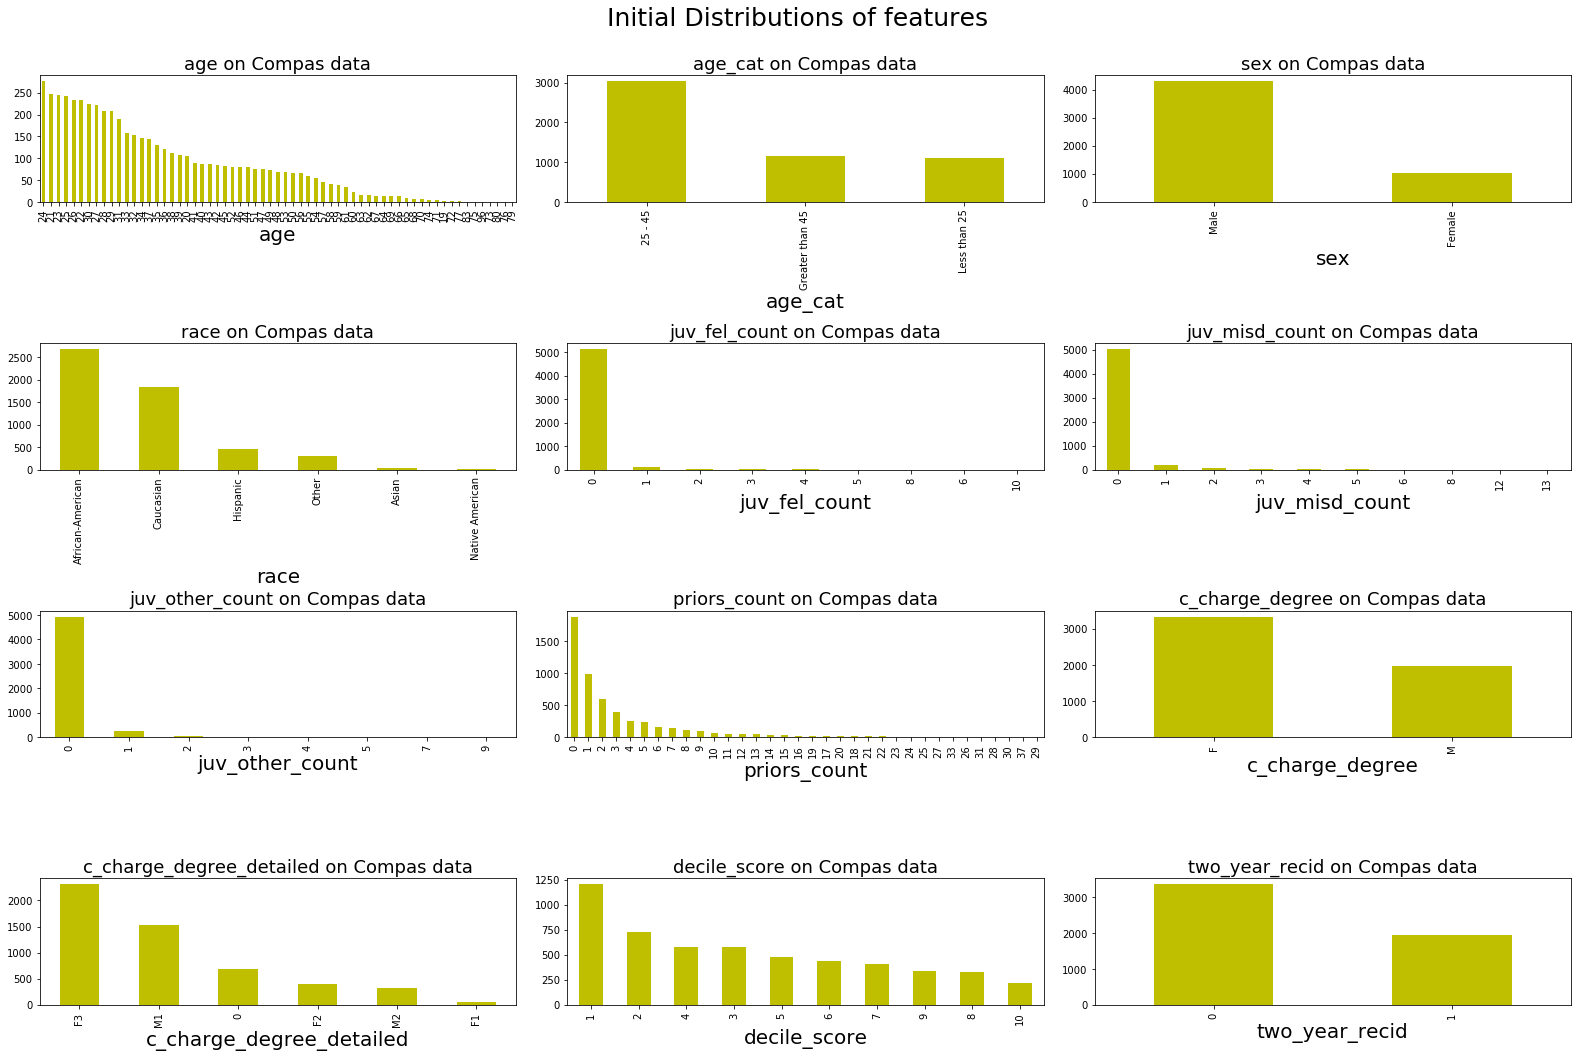

In [138]:

def plot_dist(col, ax):
    df[col][df[col].notnull()].value_counts().plot(kind='bar', facecolor='y', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=20)
    ax.set_title("{} on Compas data".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(4,3, figsize = (22,15))
f.tight_layout(h_pad=12, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = [ "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_degree_detailed", #current charges
           "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "two_year_recid"]
k = 0
for i in range(4):
    for j in range(3):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Initial Distributions of features", fontsize= 25)

Let us take a look closer into decile_score / race of African-American and Caucasian. 
The difference in scores leads to drastically different racial make-up per decile.

In [139]:
cols = ['race', 'decile_score']
df_race = df[cols].loc[lambda x:x['race'].isin(['African-American', 'Caucasian'])]

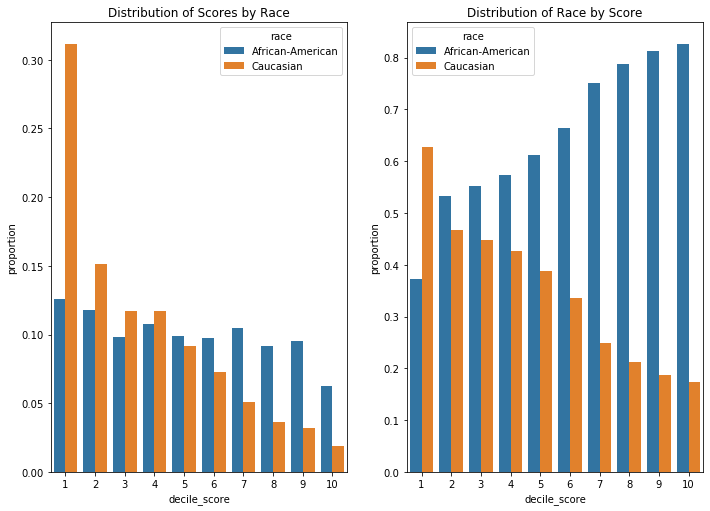

In [140]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(11.7, 8.27)
a1 = (
    df_race
    .groupby(['race'])['decile_score']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
    .sort_values(by='decile_score')
)

sns.barplot(data=a1, x='decile_score' ,y='proportion',hue='race', ax=ax1)
ax1.set_title('Distribution of Scores by Race')

a2 = (
    df_race
    .groupby(['decile_score'])['race']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
    .sort_values(by='race')
)

sns.barplot(data=a2, x='decile_score' ,y='proportion',hue='race', ax=ax2);
ax2.set_title('Distribution of Race by Score');

There is a big difference in distribution of race by score and another way around.
We decide to split the model into one with race and one without race.

### Fill in missing data for c_charge_degree_detailed

In [141]:
#fill missing data with mode as the value that appears the most in the set of values
df.fillna(df.c_charge_degree_detailed.mode().iloc[0], inplace=True)

In [142]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df[df.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed


# Regression

## Selection of features for the model

### Model with race

#### Featuring and start fitting base model

**Featuring age cat**

In [146]:
features = pd.concat([pd.get_dummies(df.age_cat, prefix='age_cat',drop_first=True),
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target = df.decile_score

**Featuring age cat preprocessing**

**Featuring age**

In [145]:
features_age = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target_age = df.decile_score

**Featuring age preprocessing**

**Splitting age cat**

In [147]:
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = ran)

**Model for age_cat before tuning**

In [148]:

xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:linear', 
                          colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True, random_state = ran
                        )
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

In [149]:
exp_xgreg = dx.Explainer(xg_reg, X_test, y_test, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,4.205694,2.050779,0.472699,1.623306,1.363565


**Splitting for age**

In [150]:
X_age = features_age
y_age = target_age
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age,y_age, test_size=0.3, random_state = ran)

**Model for age before tuning**


In [151]:
xg_reg_age = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:squarederror', 
                          colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1,verbosity=0, silent = True, random_state = ran)
xg_reg_age.fit(X_train_age,y_train_age)
y_pred_age = xg_reg_age.predict(X_test_age)

In [152]:
exp_xgreg_age = dx.Explainer(xg_reg_age, X_test_age, y_test_age, verbose=False)
exp_xgreg_age.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,3.976696,1.994166,0.50141,1.565929,1.302204


In [153]:
exp_xgreg_age.model_parts().plot()

Since model with age, we continue with age

**Splitting Train Test split again for age for further use**

In [157]:
X= features_age
y= target_age
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = ran)

#### Tuning XGBoost with RandomizedSearchCV

In [158]:
# model tuning
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[50,100,150],
    'min_child_weight':[2,3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'learning_rate':[i/10.0 for i in range(2,11)],
}

reg = XGBRegressor()

# run randomized search
n_iter_search = 250
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='r2',random_state = ran)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 272.29 seconds for 250 candidates parameter settings.


In [159]:
#print out te best estimator
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eta=0.4, eval_metric='rmse', gamma=0.3, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=2,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [160]:
#plug the best estimatior to predict y and find r2 score
best_regressor = random_search.best_estimator_
y_pred = best_regressor.predict(X_test)
r2_score(y_test,y_pred)

0.5015336052151564

#### Tuning the number of boosting round (n_estimator)

We go deeper into n_estimators in the range from 80-120

In [161]:
params_0 = {
    'n_estimators': np.arange(80,120,5)
}
gsearch0 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.3, learning_rate=0.2, 
                          max_depth=2, min_child_weight=4, objective='reg:linear', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9, importance_type='gain',
                          max_delta_step=0, subsample=0.8, verbosity=0, silent=True, random_state = ran, seed = seed),param_grid = params_0, cv=5)
gsearch0.fit(X_train,y_train)
gsearch0.best_params_, gsearch0.best_score_

({'n_estimators': 95}, 0.5052956363270076)

Take one more step deeper into the range from 90 to 100

In [162]:
params_0 = {
    'n_estimators': np.arange(90,100,1)
}
gsearch0 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.3, learning_rate=0.2, 
                          max_depth=2, min_child_weight=4, objective='reg:linear', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9, importance_type='gain',
                          max_delta_step=0, subsample=0.8, verbosity=0, silent=True, random_state = ran, seed = seed),param_grid = params_0, cv=5)
gsearch0.fit(X_train,y_train)
gsearch0.best_params_, gsearch0.best_score_

({'n_estimators': 95}, 0.5052956363270076)

#### Using GridSearch to tune max_depth and min_child_weight

In [163]:
params_1 = {
 'max_depth':range(1,4,1),
 'min_child_weight':range(1,5,1)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.3, learning_rate=0.2, 
                          objective='reg:linear', n_estimators = 95,
                          olsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9, importance_type='gain',
                          max_delta_step=0, subsample=0.8, verbosity=0, silent = True, random_state = ran, seed = seed),param_grid = params_1, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 2, 'min_child_weight': 4}, 0.5052956363270076)

#### Tuning gamma

In [164]:
params_2 = {
 'gamma':[i/10.0 for i in range(1,6)]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', learning_rate=0.2, 
                          objective='reg:linear',  n_estimators = 95,
                          colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9, importance_type='gain',
                          max_delta_step=0, subsample=0.8, verbosity=0, silent = True, max_depth=2, min_child_weight=4, random_state = ran, seed = seed),param_grid = params_2, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.1}, 0.5052956363270076)

#### Tunning subsample and colsample_bytree

In [165]:
params_3 = {
    'subsample':[i/10.0 for i in range(9,12)],
    'colsample_bytree':[i/10.0 for i in range(9,12)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.1, learning_rate=0.2, 
                          objective='reg:linear',  n_estimators = 95,
                          colsample_bylevel=1, colsample_bynode=1, importance_type='gain',
                          max_delta_step=0, verbosity=0, silent = True, max_depth=2, min_child_weight=4, random_state = ran, seed = seed),param_grid = params_3, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


25 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packag

({'colsample_bytree': 1.0, 'subsample': 1.0}, 0.5060693725384681)

#### Tuning L1 Regulation

In [168]:
params_4 = {
    'reg_alpha':[0, 1, 0.05]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.1, learning_rate=0.2,
                          objective='reg:linear', n_estimators = 95,
                          colsample_bylevel=1, colsample_bynode=1, importance_type='gain',
                          max_delta_step=0, verbosity=0, silent = True, max_depth=2, min_child_weight=4,subsample=1,colsample_bytree=1, random_state = ran, seed = seed),param_grid = params_4, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

({'reg_alpha': 1}, 0.5069749048871939)

#### Tuning Learning rate

In [170]:
params_5 = {
    'learning_rate':np.arange(0.1,0.4,0.1)
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.1,
                           objective='reg:linear',  n_estimators = 95,
                          colsample_bylevel=1, colsample_bynode=1, importance_type='gain',subsample=1,colsample_bytree=1,
                          max_delta_step=0, verbosity=0, silent = True, max_depth=2, min_child_weight=4, reg_alpha=1, random_state = ran, seed = seed),param_grid = params_5, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

({'learning_rate': 0.2}, 0.5069749048871939)

#### Testing with new tuned parameters

In [172]:
xg_reg_tuned = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.1, learning_rate = 0.2,
                           objective='reg:linear',  n_estimators = 95,
                          colsample_bylevel=1, colsample_bynode=1, importance_type='gain',subsample=1,colsample_bytree=1,
                          max_delta_step=0, verbosity=0, silent = True, max_depth=2, min_child_weight=4, reg_alpha=1, random_state = ran, seed = seed)
xg_reg_tuned.fit(X_train, y_train)
y_pred = xg_reg_tuned.predict(X_test)

In [173]:
exp_xgreg_tuned = dx.Explainer(xg_reg_tuned, X_test, y_test, verbose=False)
exp_xgreg_tuned.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,4.019553,2.004882,0.496037,1.571746,1.300764


### Model without race

#### Featuring and start fitting base model

**Featuring model (we continue with age)**

In [174]:
features = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    ##pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target = df.decile_score

In [175]:
X = features
y =target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = ran)

**Model for age before tuning**

In [176]:

xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:linear', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True, random_state = ran
                        )
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

In [177]:
exp_xgreg = dx.Explainer(xg_reg, X_test, y_test, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,4.12499,2.031007,0.482817,1.592623,1.289819


#### Tuning XGBoost with RandomizedCV

In [178]:
# model tuning
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[50,100,150],
    'min_child_weight':[2,3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'learning_rate':[i/10.0 for i in range(2,11)],
}

reg = XGBRegressor()

# run randomized search
n_iter_search = 250
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='r2', random_state = ran)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 175.49 seconds for 250 candidates parameter settings.


In [179]:
#plug the best estimatior to predict y and find r2 score
best_regressor = random_search.best_estimator_
y_pred = best_regressor.predict(X_test)
r2_score(y_test,y_pred)

0.47950759578484425

In [180]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             eta=0.4, eval_metric='rmse', gamma=0.3, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1,
             verbosity=None)

Lets do another Grid Search Tuning here.
Also based on the tuning process for model with race, we don't see any changes after tuning gamma, learning_rate, max_depth and min_child_weight since they are already on the lowest level. Hence, we minimize this part for the model without race

#### Tuning with GridSearchCV

In [182]:
params = {
    'n_estimators':[47,52,1],
    'gamma':[i/10.0 for i in range(2,4)]
}
gsearch = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.3, 
                          objective='reg:squarederror',
                          colsample_bylevel=1, colsample_bynode=1, importance_type='gain',subsample=0.8,colsample_bytree=0.6,
                          max_delta_step=0, verbosity=0, silent = True, max_depth=3, min_child_weight=5, reg_alpha=0,learning_rate = 0.2, random_state = ran, seed = seed),param_grid = params, cv=5)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch5.best_score_

({'gamma': 0.2, 'n_estimators': 52}, 0.5069749048871939)

#### Testing with new tuned parameters

In [183]:
best_regressor = gsearch.best_estimator_
y_pred = best_regressor.predict(X_test)
r2_score(y_test,y_pred)

0.4781945612681374

After tuning, model with "race" has a higher R2_score compared to the one without "race". We can see that "race" plays a roll in predicting the decile score. 

# Classification

### Selection of features for the model

We keep using race and age for our classification part.

### Model with race

In [255]:
features = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count
                    ],
                    axis=1)

target = df.two_year_recid

**Splitting train, test**

In [256]:
X = features
y =target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = ran)

**model with default params**

In [257]:

xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='binary:logistic', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True, random_state = ran
                        )
xg_clf.fit(X_train,y_train)
y_pred = xg_clf.predict(X_test)

In [258]:
roc_auc_score(y_test,y_pred)

0.6465814134442979

**Tuning XGBoost for clf**

In [259]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# model tuning
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[50,100,150],
    'min_child_weight':[2,3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['binary:logistic'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'verbosity':[0],
    'silent':[True]
}

clf = XGBClassifier(verbosity = 0,silent =True)

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='r2', random_state = ran)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 77.14 seconds for 100 candidates parameter settings.


In [263]:
best_regressor = random_search.best_estimator_
y_pred = best_regressor.predict(X_test)
roc_auc_score(y_pred,y_test)

0.6659639856683963

In [264]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eta=0.3, eval_metric='rmse', gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.9, tree_method='exact',
              validate_parameters=1, ...)

#### Tuning number of boosting round

In [265]:
params0 = {
    'n_estimators':[25,80,5],
}
gsearch0 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', gamma=0.5, 
                          objective='binary:logistic',learning_rate = 0.3,
                          colsample_bylevel=1, colsample_bynode=1, importance_type='gain',subsample=0.9,colsample_bytree=1,
                          verbosity=0, silent = True, max_depth=2, min_child_weight=3, reg_alpha=0, random_state = ran, seed = seed),param_grid = params0, cv=5)
gsearch0.fit(X_train,y_train)
gsearch0.best_params_, gsearch0.best_score_

({'n_estimators': 25}, 0.7130961752638281)

#### Tuning subsample, colsample_bytree, l1 Regulation and learning rate

In [285]:
params3 = {
    'subsample':[0.1,1,0.05],
    'colsample_bytree':[0.1,1,0.05],
    'reg_alpha':[0.1,1,0.05],
    'learning_rate':[0.1,0.4,0.1], 
    'max_depth':[1,3,1],
    'min_child_weight':[1,5,1]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', gamma = 0.1,
                          objective='binary:logistic',  n_estimatos = 25,
                          colsample_bylevel=1, colsample_bynode=1, importance_type='gain',
                          verbosity=0, silent = True,random_state = ran, seed = seed),param_grid = params3, cv=5, scoring = 'roc_auc')
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 1,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 1,
  'reg_alpha': 1,
  'subsample': 1},
 0.7441437379191461)

#### Tuning subsample and colsample_bytree

In [291]:
xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', gamma = 0.1,
                          objective='binary:logistic', n_estimatos = 25, learning_rate = 0.1,
                          colsample_bylevel=1, colsample_bynode=1, importance_type='gain',subsample=1,colsample_bytree=1,
                          verbosity=0, silent = True,  max_depth=3, min_child_weight=1, reg_alpha=0,random_state = ran, seed = seed
                        )
xg_clf.fit(X_train,y_train)
y_pred = xg_clf.predict(X_test)

In [292]:
roc_auc_score(y_pred,y_test)

0.6739192306690158

In [293]:
confusion_matrix(y_test, y_pred)

array([[841, 161],
       [322, 268]])

In [294]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.72      0.84      0.78      1002
    is_recid       0.62      0.45      0.53       590

    accuracy                           0.70      1592
   macro avg       0.67      0.65      0.65      1592
weighted avg       0.69      0.70      0.68      1592

